## Домашнее задание к лекции «Поиск выбросов и генерация новых признаков»
Преподаватель: Алексей Миронов, Наталья Баданина, Дарья Максимова

Задание к домашней работе

    Теперь решаем задачу регрессии - предскажем цены на недвижимость.
    Использовать датасет https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data (train.csv)
    Данных немного, поэтому необходимо использовать 10-fold кросс-валидацию для оценки качества моделей
    Построить случайный лес, вывести важность признаков
    Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную
    Для валидации модели 2-го уровня использовать отдельный hold-out датасет, как на занятии
    Показать, что использование ансамблей моделей действительно улучшает качество (стекинг vs другие модели сравнивать на hold-out)
    В качестве решения: Jupyter notebook с кодом, комментариями и графиками




## Imports & Load Data

In [185]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from jupyterthemes import jtplot
from sklearn.metrics import auc, roc_curve, roc_auc_score
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, cross_validate, KFold, train_test_split
from sklearn.ensemble import StackingClassifier, StackingRegressor, BaggingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.svm import NuSVR
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostRegressor

%matplotlib inline
jtplot.style()
import warnings
warnings.filterwarnings("ignore")

In [186]:
# %%bash
# kaggle competitions download -c house-prices-advanced-regression-techniques
# unzip house-prices-advanced-regression-techniques.zip

In [187]:
os.listdir()

['.ipynb_checkpoints',
 'ansambling.ipynb',
 'ansambling_2.ipynb',
 'data_description.txt',
 'house-prices-advanced-regression-techniques.zip',
 'img',
 'sample_submission.csv',
 'test.csv',
 'train.csv',
 '__MACOSX',
 'Ð\x90Ð½Ñ\x81Ð°Ð¼Ð±Ð»ÐµÐ²Ñ\x8bÐµ Ð¼Ð¾Ð´ÐµÐ»Ð¸.ipynb']

In [188]:
train = pd.read_csv('train.csv')
train.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [189]:
y = train.SalePrice
X = train.drop(['SalePrice', 'Id'], 1)

## Light EDA

In [190]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0
BsmtFinSF2,1460.0,46.549315,161.319273,0.0,0.00,0.0,0.00,1474.0


In [191]:
X.isna().sum()[X.isna().sum() != 0]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

Удаляем колонки с количеством NA больше 690

In [192]:
drop_cols = X.isna().sum()[train.isna().sum() >= 690]
X.drop(drop_cols.index, 1, inplace=True)

Lot Frontage: Linear feet of street connected to property

Похоже это просто длина фасада продаваемого участка, и там где его нет - NA

Заменим:

In [193]:
print(np.corrcoef(X.LotFrontage.fillna(0), y)[0,1],
      np.corrcoef(X.LotFrontage.fillna(X.LotFrontage.mean()), y)[0,1],
      np.corrcoef(X.LotFrontage.fillna(X.LotFrontage.median()), y)[0,1],
      X.LotFrontage.corr(y),
      sep='\n')

0.20962394479948393
0.33490085154055105
0.33477085313976007
0.35179909657067804


Заменим на среднее значение

Здесь стоит обратить внимание на то, что еще выше корреляция, посчитанная с удалением НА,

Поэтому создадим еще одну переменную: есть ли нет фасада

In [194]:
X['Is_Frontage'] = ~X.LotFrontage.isna()

In [195]:
X.LotFrontage.fillna(X.LotFrontage.mean(), inplace=True)

MasVnrType: Masonry veneer type, MasVnrArea: Masonry veneer area in square feet

Тип и площадь облицовки, НА заменяем на None с пощадью ноль

<AxesSubplot:>

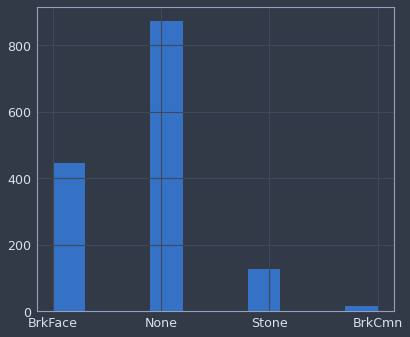

In [196]:
X.MasVnrArea.fillna(0, inplace=True)
X.MasVnrType.fillna('None', inplace=True)
X.MasVnrType.hist()

Причем это категориальный тип данных, для преобразования в дальнейшем,

создадим список таких колонок

In [197]:
dummy_cols = ['MasVnrType',]

BsmtQual: Высота подвала

BsmtCond: Общее состояние подвала.

BsmtExposure: Подвальные стены на уровне сада или выхода

BsmtFinType1: Качество готовой площади подвала

BsmtFinType2: Качество второй законченной области (если есть)

в этих колонках NA - отсутствие подвала, поэтому для всех колонок вводим категорию NB - без подвала,

И создаем еще одну фичу - наличие подвала

In [198]:
basement = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtUnfSF', 'TotalBsmtSF']
X[basement][X.BsmtFinType2.isna()].head()

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtUnfSF,TotalBsmtSF
17,NaN,NaN,NaN,NaN,NaN,0,0
39,NaN,NaN,NaN,NaN,NaN,0,0
90,NaN,NaN,NaN,NaN,NaN,0,0
102,NaN,NaN,NaN,NaN,NaN,0,0
156,NaN,NaN,NaN,NaN,NaN,0,0


In [199]:
X['is_basement'] = X.BsmtExposure.isna()
X[basement] = X[basement].fillna('NB')
dummy_cols += ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']

<AxesSubplot:>

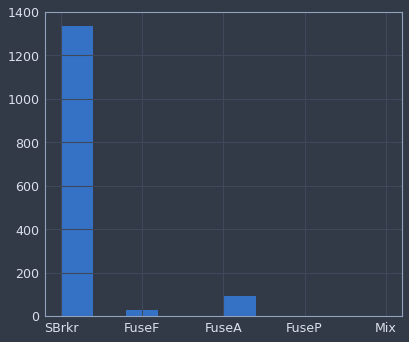

In [200]:
X.Electrical.hist()

Electrical одно значение НА заменим на SBrkr

In [201]:
X.Electrical.fillna('SBrkr', inplace=True)

GarageType: расположение гаража
    
GarageYrBlt: Год постройки гаража
    
GarageFinish: Внутренняя отделка гаража.
    
GarageCars: Размер гаража по вместимости машины
    
GarageArea: Размер гаража в квадратных футах.
    
GarageQual: качество гаража
    
GarageCond: Состояние гаража
    
То же, там где нет гаража - данные отсутствуют

In [202]:
garage_cols = ['GarageType', 'GarageFinish', 'GarageQual','GarageCond']

In [203]:
X[garage_cols] = X[garage_cols].fillna('NG')
X.GarageYrBlt = 2020 - X.GarageYrBlt
X.GarageYrBlt.fillna(0, inplace=True)
dummy_cols += garage_cols
dummy_cols

['MasVnrType',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond']

In [204]:
X.isna().sum()[X.isna().sum() != 0]

Series([], dtype: int64)

Год постройки b год продажи заменим на возраст

In [205]:
X.YearBuilt = 2020 - X.YearBuilt
X.YrSold = 2020 - X.YrSold

X

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,Is_Frontage,is_basement
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,2,12,WD,Normal,True,False
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,5,13,WD,Normal,True,False
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,9,12,WD,Normal,True,False
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,0,0,2,14,WD,Abnorml,True,False
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,12,12,WD,Normal,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,8,13,WD,Normal,True,False
1456,20,RL,85.0,13175,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,2,10,WD,Normal,True,False
1457,70,RL,66.0,9042,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,2500,5,10,WD,Normal,True,False
1458,20,RL,68.0,9717,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,4,10,WD,Normal,True,False


In [206]:
dummy_cols = list(X.dtypes[X.dtypes == 'object'].index)
dummy_cols

['MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'SaleType',
 'SaleCondition']

Создаем два набора данных для разного представления категориальных признаков

X_dummies - one hot encoding

X_le - label encoding

In [207]:
X_dummies = pd.get_dummies(X, columns=dummy_cols)

In [208]:
X_le = X
for col in dummy_cols:
    le = LabelEncoder()
    X_le[col] = le.fit_transform(X_le[col])
X_le

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,Is_Frontage,is_basement
0,60,3,65.0,8450,1,3,3,0,4,0,...,0,0,0,0,2,12,8,4,True,False
1,20,3,80.0,9600,1,3,3,0,2,0,...,0,0,0,0,5,13,8,4,True,False
2,60,3,68.0,11250,1,0,3,0,4,0,...,0,0,0,0,9,12,8,4,True,False
3,70,3,60.0,9550,1,0,3,0,0,0,...,0,0,0,0,2,14,8,0,True,False
4,60,3,84.0,14260,1,0,3,0,2,0,...,0,0,0,0,12,12,8,4,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,3,62.0,7917,1,3,3,0,4,0,...,0,0,0,0,8,13,8,4,True,False
1456,20,3,85.0,13175,1,3,3,0,4,0,...,0,0,0,0,2,10,8,4,True,False
1457,70,3,66.0,9042,1,3,3,0,4,0,...,0,0,0,2500,5,10,8,4,True,False
1458,20,3,68.0,9717,1,3,3,0,4,0,...,0,0,0,0,4,10,8,4,True,False


## Отделяем hold-out

In [209]:
X_le, X_hold, y, y_hold = train_test_split(X, y, test_size=0.2, random_state=42)

## Случайный лес

In [210]:
# Подготовим функцию для кросс-валидации и обучим дерево решений

def learn_regressor(X, y,
                    estimator,
                    polyfeatures=False,
                    norm=False,
                    n_splits=10,
                    pca_components=None,
                    random=42):
    score = []
    list_estimators = []
    if polyfeatures:
        poly = PolynomialFeatures()
        poly_X = poly.fit_transform(X)
        X = pd.DataFrame(poly_X, columns=poly.get_feature_names())
    if pca_components:
        pca = PCA(n_components=pca_components, svd_solver='auto')
        X = pd.DataFrame(pca.fit_transform(X))

    for n, (train, test) in enumerate(KFold(n_splits=n_splits, random_state=random, shuffle=True).split(y)):
        
        X_train = X.iloc[train]
        X_test = X.iloc[test]
        if norm:
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
        estimator = estimator.fit(X_train, y.iloc[train])        
        sc = estimator.score(X_test, y.iloc[test])
        score.append(sc)
        list_estimators.append(estimator)
        print(f'Fold {n}, R^2 coeff = {sc}')
    print(f'mean R^2 = {np.array(score).mean()}')
    
    return list_estimators
    

reg_rf = RandomForestRegressor( n_estimators=300,
                                max_depth=13,
                                max_features=0.75,
                                random_state=42,
                                n_jobs=-1)
list_rf_models = learn_regressor(X_le, y,
                                 estimator=reg_rf,
                                 # pca_components='mle', 
                                 polyfeatures=False,
                                 norm=True)

Fold 0, R^2 coeff = 0.8425441601422746
Fold 1, R^2 coeff = 0.9092806918594097
Fold 2, R^2 coeff = 0.8292566313549437
Fold 3, R^2 coeff = 0.7722461512360448
Fold 4, R^2 coeff = 0.8923075877353319
Fold 5, R^2 coeff = 0.7988760813113309
Fold 6, R^2 coeff = 0.8983162433379264
Fold 7, R^2 coeff = 0.8942486639195769
Fold 8, R^2 coeff = 0.9013427848958537
Fold 9, R^2 coeff = 0.8787800664268126
mean R^2 = 0.8617199062219505


Случайный лес:

mean R^2 = 0.8617199062219505


##  Важность признаков

In [211]:
imp = pd.DataFrame(index=X_le.columns,)
for i in range(5): 
    imp = imp.join(pd.DataFrame(data=list_rf_models[i].feature_importances_,
                   index=X_le.columns,
                   columns=[f'importances_fold_{i}']))
imp['importances'] = imp.mean(1)
imp = imp.sort_values(by='importances', ascending=False)

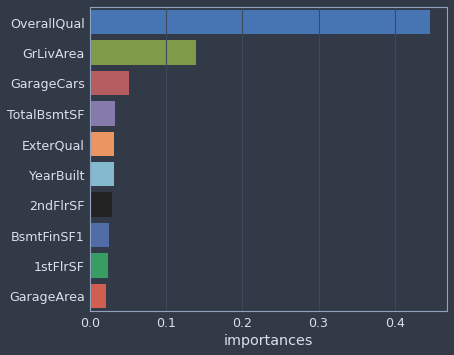

In [212]:
# Посмотрим на первые 10
imp = imp[:10]
sns.barplot(x='importances', y=imp.index, data=imp);

## Стекинг


In [213]:
# Линейная регрессия
list_linear_models = learn_regressor(X_le, y,
                                 LinearRegression(),
                                 pca_components=50,
                                 polyfeatures=False,
                                 norm=True)

Fold 0, R^2 coeff = 0.8305233773473333
Fold 1, R^2 coeff = 0.8616285033158111
Fold 2, R^2 coeff = 0.8267830380109799
Fold 3, R^2 coeff = 0.7274927600917498
Fold 4, R^2 coeff = 0.8894727755012699
Fold 5, R^2 coeff = 0.46867989851862957
Fold 6, R^2 coeff = 0.8443815331666048
Fold 7, R^2 coeff = 0.865851304953455
Fold 8, R^2 coeff = 0.8944637403763878
Fold 9, R^2 coeff = 0.839090419824949
mean R^2 = 0.8048367351107171


In [214]:
# SVM
svr = make_pipeline(StandardScaler(), NuSVR(C=3e5, nu=0.9, gamma='auto'))
list_svr = learn_regressor(X_le, y, svr, polyfeatures=False, norm=False)

Fold 0, R^2 coeff = 0.827788852462267
Fold 1, R^2 coeff = 0.8471785355968051
Fold 2, R^2 coeff = 0.7845324295718445
Fold 3, R^2 coeff = 0.8761905854063441
Fold 4, R^2 coeff = 0.9241577676002753
Fold 5, R^2 coeff = 0.5721953773984506
Fold 6, R^2 coeff = 0.76576841644318
Fold 7, R^2 coeff = 0.8549427542178146
Fold 8, R^2 coeff = 0.8908222649115646
Fold 9, R^2 coeff = 0.7971205956449433
mean R^2 = 0.8140697579253489


In [215]:
# AdaBoost
tree_params = {'criterion': 'mse',
              'splitter': 'best',
              'max_depth': 7,
              'min_samples_split': 30,
              'min_samples_leaf': 3,
              'min_weight_fraction_leaf': 0.0,
              'max_features': None,
              'min_impurity_decrease': 0.0,
              'min_impurity_split': None,
              'ccp_alpha': 0.0,}
tree = DecisionTreeRegressor(random_state=42, **tree_params)
ada = AdaBoostRegressor(base_estimator=tree,
                        n_estimators=200,
                        learning_rate=1,
                        random_state=42,)
list_ada = learn_regressor(X_le, y, ada, polyfeatures=False, norm=False)

Fold 0, R^2 coeff = 0.8055705478376299
Fold 1, R^2 coeff = 0.8950592317099535
Fold 2, R^2 coeff = 0.8230673317124473
Fold 3, R^2 coeff = 0.8267366725485046
Fold 4, R^2 coeff = 0.8819460335148193
Fold 5, R^2 coeff = 0.8782415207892131
Fold 6, R^2 coeff = 0.8819387523298153
Fold 7, R^2 coeff = 0.8969592368363927
Fold 8, R^2 coeff = 0.8890232242116023
Fold 9, R^2 coeff = 0.8745308192196657
mean R^2 = 0.8653073370710043


adaBoost:

0.8653073370710043

In [216]:
# Bagging
bagging = BaggingRegressor(base_estimator=tree, n_estimators=300, random_state=42)
list_bagging = learn_regressor(X_le, y, bagging, polyfeatures=False, norm=False)

Fold 0, R^2 coeff = 0.8113512103789784
Fold 1, R^2 coeff = 0.8727261373906091
Fold 2, R^2 coeff = 0.8231132506390153
Fold 3, R^2 coeff = 0.789859142351502
Fold 4, R^2 coeff = 0.8426954280680843
Fold 5, R^2 coeff = 0.7378317935546208
Fold 6, R^2 coeff = 0.853748398581925
Fold 7, R^2 coeff = 0.855462928153514
Fold 8, R^2 coeff = 0.868948499981157
Fold 9, R^2 coeff = 0.8474720184173156
mean R^2 = 0.8303208807516722


In [237]:
regressor = StackingRegressor(
    
    [   #('lr', LinearRegression()),
        ('bagging', bagging),
        ('svr', svr), # support vector regressor
        ('rf', reg_rf), # random forest
        ('ada', ada) # adaboost
    ],
        LinearRegression()
) 

In [238]:
%%time
list_regressors = learn_regressor(X_le, y, regressor, polyfeatures=False, norm=False)

Fold 0, R^2 coeff = 0.8503615231768837
Fold 1, R^2 coeff = 0.9257353917386628
Fold 2, R^2 coeff = 0.8221407571132802
Fold 3, R^2 coeff = 0.8109036932449428
Fold 4, R^2 coeff = 0.9300002087595967
Fold 5, R^2 coeff = 0.7665947389157763
Fold 6, R^2 coeff = 0.8998274155325672
Fold 7, R^2 coeff = 0.9234113549924452
Fold 8, R^2 coeff = 0.932962290982463
Fold 9, R^2 coeff = 0.8846417724455359
mean R^2 = 0.8746579146902154
CPU times: user 9min 1s, sys: 4.66 s, total: 9min 5s
Wall time: 9min 18s


Stacking:

mean R^2 = 0.8746579146902154

## Проверяем модели на отложенной выборке

In [247]:
def hold_score(list_models):
    preds = []
    for model in list_models:
        preds.append(model.predict(X_hold))
    y_pred = np.array(preds).reshape((10, -1)).mean(0)
    return  r2_score(y_hold, y_pred)

In [248]:
# support vector regressor
hold_score(list_svr)

0.7674800489010536

In [249]:
# adaboost
hold_score(list_ada)

0.9070085644452512

In [250]:
# Bagging
hold_score(list_bagging)

0.8430498301934252

In [251]:
# Stacking
hold_score(list_regressors)

0.9161394270276924

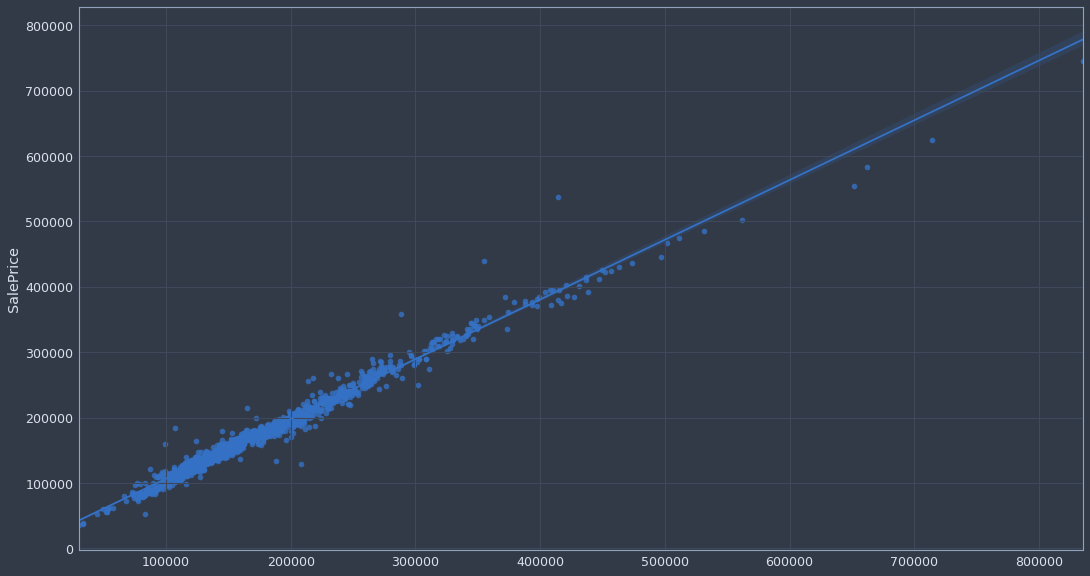

In [252]:
pred = np.mean([reg.predict(X_le) for reg in list_regressors], 0)
plt.figure(figsize=(18,10))
sns.regplot(pred, y);

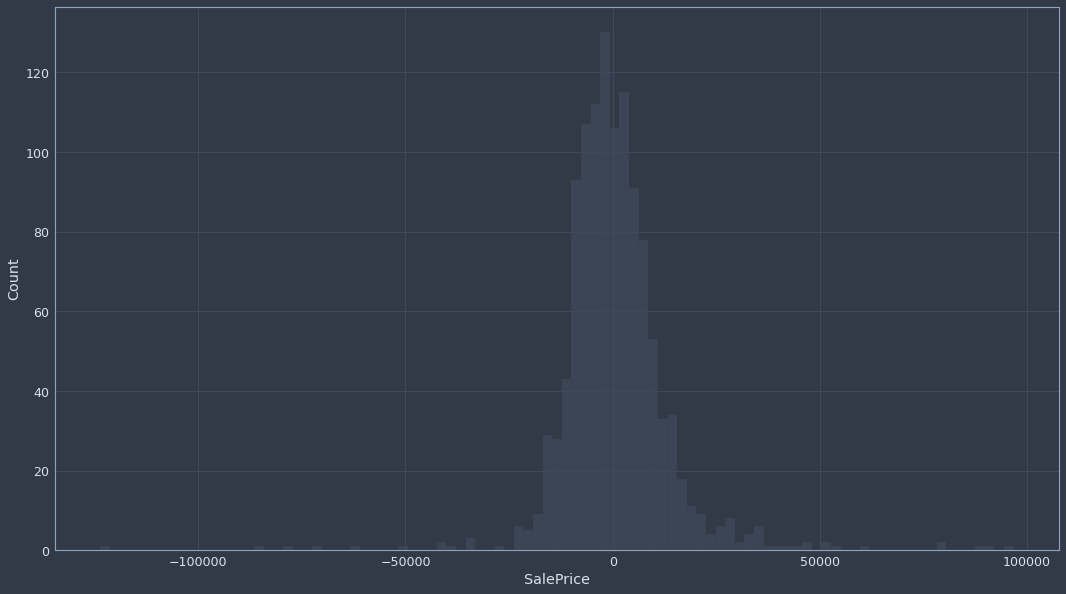

In [253]:
plt.figure(figsize=(18,10))
sns.histplot((pred-y));

In [254]:
np.corrcoef(pred, y)

array([[1.        , 0.98897313],
       [0.98897313, 1.        ]])

Использование ансамблей моделей действительно улучшает качество моделей, мы получили ансамбль с качесвом R^2 = 0.9161394270276924, что 

Это самое высокое значение среди всех отдельно взятых моделей